In [ ]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("..")
import torch as th

device = "cpu"

In [ ]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")
import torch as th
from pathlib import Path
import json
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

BASE_DIR = Path("..")

CHECKPOINT_DIR = BASE_DIR / "checkpoints" / "feature_scaler"
PLOTS_DIR = BASE_DIR / "plots"
device = "cuda" if th.cuda.is_available() else "cpu"
device

In [25]:
one_init_names = ["S4-L13-mu0.0e+00-lr1e-02", "S42-L13-mu0.0e+00-lr1e-02", "S666-L13-mu0.0e+00-lr1e-02"]
zero_init_names = ["S4-L13-mu0.0e+00-lr1e-02-ZeroInit", "S42-L13-mu0.0e+00-lr1e-02-ZeroInit", "S666-L13-mu0.0e+00-lr1e-02-ZeroInit"]

random_indices_names = ["RandomIndicesL13-mu0.0e+00-lr1e-02", "RandomIndicesS4-L13-mu0.0e+00-lr1e-02", "RandomIndicesS666-L13-mu0.0e+00-lr1e-02"]
random_sources_names = ["RandomSourceL13-mu0.0e+00-lr1e-02", "RandomSourceS4-L13-mu0.0e+00-lr1e-02", "RandomSourceS666-L13-mu0.0e+00-lr1e-02"]
full_scaler_name = "L13-mu0.0e+00-lr1e-02-full"

base_model_fve = 0.83579

def load_fve(name):
    with open(CHECKPOINT_DIR / name / "last_eval_logs.json", "r") as f:
        return json.load(f)["val/frac_variance_explained"]
one_init_fve = [load_fve(name) for name in one_init_names]
zero_init_fve = [load_fve(name) for name in zero_init_names]
random_indices_fve = [load_fve(name) for name in random_indices_names]
random_sources_fve = [load_fve(name) for name in random_sources_names]
full_scaler_fve = load_fve(full_scaler_name)

In [ ]:
# bar plot with std for one_init
one_init_fve_mean = np.mean(one_init_fve)
one_init_fve_std = np.std(one_init_fve)
zero_init_fve_mean = np.mean(zero_init_fve)
zero_init_fve_std = np.std(zero_init_fve)
random_indices_fve_mean = np.mean(random_indices_fve)
random_indices_fve_std = np.std(random_indices_fve)
random_sources_fve_mean = np.mean(random_sources_fve)
random_sources_fve_std = np.std(random_sources_fve)

# Calculate relative improvements
rel_one_init = (one_init_fve_mean - base_model_fve) / base_model_fve * 100
rel_zero_init = (zero_init_fve_mean - base_model_fve) / base_model_fve * 100
rel_random_indices = (random_indices_fve_mean - base_model_fve) / base_model_fve * 100
rel_random_sources = (random_sources_fve_mean - base_model_fve) / base_model_fve * 100
rel_full_scaler = (full_scaler_fve - base_model_fve) / base_model_fve * 100

# Convert std to relative
rel_one_init_std = one_init_fve_std / base_model_fve * 100
rel_zero_init_std = zero_init_fve_std / base_model_fve * 100
rel_random_indices_std = random_indices_fve_std / base_model_fve * 100
rel_random_sources_std = random_sources_fve_std / base_model_fve * 100

fig = px.bar(
    x=["S_I 1-init", "S_I Zero Init", "Random Set <br> 1-init", "Random Vectors <br> 1-init"],
    y=[rel_one_init, rel_zero_init, rel_random_indices, rel_random_sources],
    title="Relative FVE Improvement Over CrossCoder (%)",
    error_y=[rel_one_init_std, rel_zero_init_std, rel_random_indices_std, rel_random_sources_std],
)

# horizontal dashed blue line at full scaler improvement
fig.add_hline(y=rel_full_scaler, line_dash="dash", line_color="blue")
fig.update_traces(texttemplate='%{y:.2f}%', textposition='auto')

# add annotation for full scaler line
fig.add_annotation(
    x=2,
    y=rel_full_scaler,
    text="Full Scaler Improvement",
    font=dict(size=16, color="blue")
)
# Add scatter points for individual runs
fig.add_trace(go.Scatter(
    x=['S_I 1-init'] * len(one_init_fve),
    y=[(fve - base_model_fve) / base_model_fve * 100 for fve in one_init_fve],
    mode='markers',
    marker=dict(color='black', size=8),
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=['S_I Zero Init'] * len(zero_init_fve), 
    y=[(fve - base_model_fve) / base_model_fve * 100 for fve in zero_init_fve],
    mode='markers',
    marker=dict(color='black', size=8),
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=['Random Set <br> 1-init'] * len(random_indices_fve),
    y=[(fve - base_model_fve) / base_model_fve * 100 for fve in random_indices_fve],
    mode='markers', 
    marker=dict(color='black', size=8),
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=['Random Vectors <br> 1-init'] * len(random_sources_fve),
    y=[(fve - base_model_fve) / base_model_fve * 100 for fve in random_sources_fve],
    mode='markers',
    marker=dict(color='black', size=8),
    showlegend=False
))

# text annotations
# font size of 20
fig.update_layout(font=dict(size=20), width=800, height=600)
# axis labels
fig.update_yaxes(title="Relative FVE Improvement (%)", title_font_size=20)
# remove x axis title
fig.update_xaxes(title="", title_font_size=20)
min_y = min(rel_one_init, rel_zero_init, rel_random_indices, rel_random_sources, rel_full_scaler)
max_y = max(rel_one_init, rel_zero_init, rel_random_indices, rel_random_sources, rel_full_scaler)
fig.update_layout(yaxis_range=[min_y-0.1, max_y+0.1])
fig.show()
fig.write_image(PLOTS_DIR / "scaler_fve_improvement.png")


In [30]:
def act_func(x):
    return th.nn.functional.elu(x) + 1


In [31]:
one_init_scalers = []
for name in one_init_names:
    scaler = th.load(CHECKPOINT_DIR / name / "scaler_0_1.pt", map_location="cpu")
    one_init_scalers.append(act_func(scaler["scaler"]).cpu().numpy())
one_init_scalers = np.stack(one_init_scalers)

# Load all zero init scalers 
zero_init_scalers = []
for name in zero_init_names:
    scaler = th.load(CHECKPOINT_DIR / name / "scaler_0_1.pt", map_location="cpu")
    zero_init_scalers.append(act_func(scaler["scaler"]).cpu().numpy())
zero_init_scalers = np.stack(zero_init_scalers)

# Load Random Indices and Random Sources scalers
random_indices_scalers = []
for name in random_indices_names:
    scaler = th.load(CHECKPOINT_DIR / name / "scaler_0_1.pt", map_location="cpu")
    random_indices_scalers.append(act_func(scaler["scaler"]).cpu().numpy())
random_indices_scalers = np.stack(random_indices_scalers)

random_sources_scalers = []
for name in random_sources_names:
    scaler = th.load(CHECKPOINT_DIR / name / "scaler_0_1.pt", map_location="cpu")
    random_sources_scalers.append(act_func(scaler["scaler"]).cpu().numpy())
random_sources_scalers = np.stack(random_sources_scalers)


In [ ]:
# Load all one init scalers
threshold = 5e-2

thres_one_init = (one_init_scalers < threshold).mean(axis=1)
thres_zero_init = (zero_init_scalers < threshold).mean(axis=1)
thres_random_indices = (random_indices_scalers < threshold).mean(axis=1)
thres_random_sources = (random_sources_scalers < threshold).mean(axis=1)


one_init_mean = thres_one_init.mean() * 100
zero_init_mean = thres_zero_init.mean() * 100
random_indices_mean = thres_random_indices.mean() * 100
random_sources_mean = thres_random_sources.mean() * 100

one_init_std = thres_one_init.std() * 100
zero_init_std = thres_zero_init.std() * 100
random_indices_std = thres_random_indices.std() * 100
random_sources_std = thres_random_sources.std() * 100

# Create bar plot
fig = px.bar(
    x=["S_I 1-init", "S_I 0-init", "Random Set <br> 1-init", "Random Vectors <br> 1-init"],
    y=[one_init_mean, zero_init_mean, random_indices_mean, random_sources_mean],
    error_y=[one_init_std, zero_init_std, random_indices_std, random_sources_std],
    title=f"Percentage of Dead Feature Scalars (beta_i < {threshold:.1})",
)

# Add text annotations
fig.update_traces(texttemplate='%{y:.1f}%', textposition='auto')

# Update layout
fig.update_layout(
    font=dict(size=20),
    width=800,
    height=600,
    yaxis_title="Percentage of Dead Scalars",
    xaxis_title=""
)

# Add min/max annotations for each bar
y_positions = [one_init_mean, zero_init_mean, random_indices_mean, random_sources_mean]
stds = [one_init_std, zero_init_std, random_indices_std, random_sources_std]
x_positions = ["1-init", "0-init", "Random Set <br> 1-init", "Random Vectors <br> 1-init"]


# Set y-axis range from 0 to slightly above max
max_y = max(one_init_mean + one_init_std, 
            zero_init_mean + zero_init_std,
            random_indices_mean + random_indices_std,
            random_sources_mean + random_sources_std)
fig.update_layout(yaxis_range=[0, max_y * 1.1])

fig.show()
fig.write_image(PLOTS_DIR / "scaler_dead_scalars.png")

In [ ]:
from plotly.subplots import make_subplots
# Create subplots in a 2x3 grid
fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=[
        # First row: One init seed comparisons
        f'1-init Seeds {i+1} vs {j+1}' 
        for i in range(3) 
        for j in range(i+1,3)
    ] + [
        # First row: One init seed comparisons
        f'1-init Seed {i+1} vs 0-init Seed {j+1}' 
        for i in range(3) 
        for j in range(i+1,3)
    ],
    vertical_spacing=0.1
)

# First row: One init seed comparisons
pairs = [(i,j) for i in range(3) for j in range(i+1,3)]
for idx, (i,j) in enumerate(pairs):
    # Create 2D histogram data for this pair
    x = np.array(one_init_scalers[i]).flatten() # Ensure 1D array
    y = np.array(one_init_scalers[j]).flatten() # Ensure 1D array
    hist2d, x_edges, y_edges = np.histogram2d(
        x,
        y,
        bins=30
    )
    
    # Add heatmap to subplot
    fig.add_trace(
        go.Heatmap(
            x=x_edges[:-1],
            y=y_edges[:-1], 
            z=np.log1p(hist2d.T),
            colorscale='Viridis',
            colorbar=dict(title='Log Count'),
            showscale=(idx==2) # only show colorbar for rightmost plot
        ),
        row=1, col=idx+1
    )

# Second row: One init vs Two init comparisons
for idx, (i,j) in enumerate(pairs):
    x = np.array(one_init_scalers[i]).flatten()
    y = np.array(zero_init_scalers[j]).flatten()
    hist2d, x_edges, y_edges = np.histogram2d(
        x,
        y,
        bins=30
    )
    
    fig.add_trace(
        go.Heatmap(
            x=x_edges[:-1],
            y=y_edges[:-1], 
            z=np.log1p(hist2d.T),
            colorscale='Viridis',
            colorbar=dict(title='Log Count'),
            showscale=(idx==2) # only show colorbar for rightmost plot
        ),
        row=2, col=idx+1
    )

# Update layout
fig.update_layout(
    title='<b>Are the same features "dying"?</b> <br>2D Distributions of Feature Scaling Values',
    width=1200,
    height=800,
    showlegend=False,
)

fig.write_image(PLOTS_DIR / "scaler_2d_histo.png")
fig.show()

# Compute refined feature indices

In [34]:
from tools.feature_utils import mask_to_indices

In [ ]:
# compute indices of dead features
all_scalers = np.concatenate([one_init_scalers, zero_init_scalers])
indices = (all_scalers < 1e-4).sum(axis=0) == all_scalers.shape[0]
# indices = mask_to_indices(th.tensor(indices))
indices.sum()

In [113]:
# dump indices to json
with open(PLOTS_DIR / "dead_feature_indices_1e-4.json", "w") as f:
    json.dump(mask_to_indices(th.tensor(indices)), f)

In [ ]:
# compute indices of dead features
all_scalers = np.concatenate([one_init_scalers, zero_init_scalers])
indices = (all_scalers < 1e-3).sum(axis=0) == all_scalers.shape[0]
# indices = mask_to_indices(th.tensor(indices))
indices.sum()

In [115]:
# dump indices to json
with open(PLOTS_DIR / "dead_feature_indices_1e-3.json", "w") as f:
    json.dump(mask_to_indices(th.tensor(indices)), f)

In [116]:
# compute indices of dead features
all_scalers = np.concatenate([one_init_scalers, zero_init_scalers])
indices = (all_scalers < 1e-2).sum(axis=0) == all_scalers.shape[0]
# indices = mask_to_indices(th.tensor(indices))
indices.sum()
# dump indices to json
with open(PLOTS_DIR / "dead_feature_indices_1e-2.json", "w") as f:
    json.dump(mask_to_indices(th.tensor(indices)), f)


In [ ]:
# Create scatter plot
fig = go.Figure(
    data=[
        go.Scatter(
            x=scaled_values_one,
            y=scaled_values_zero,
            mode="markers",
            marker=dict(color="blue", opacity=0.5),
        )
    ]
)

# Update layout
fig.update_layout(
    title="Scatter Plot of Feature Scaling Values",
    xaxis_title="One Init Scaling Factor",
    yaxis_title="Zero Init Scaling Factor",
)

fig.show()

# Individual Analysis

In [1]:
from tiny_dashboard import OfflineFeatureCentricDashboard
from huggingface_hub import hf_hub_download
import pandas as pd
import torch as th
import numpy as np
import plotly.graph_objects as go


In [2]:
repo_id = "Butanium/max-activating-examples-gemma-2-2b-l13-mu4.1e-02-lr1e-04"

df_path = hf_hub_download(repo_id=repo_id, filename="feature_df.csv", repo_type="dataset")
df = pd.read_csv(df_path, index_col=0)
df

,tag,dead,dec_norm_diff,base uselessness score,avg_activation,lmsys_ctrl_%,lmsys_bos_%,lmsys_user_%,lmsys_assistant_%,lmsys_dead,...,lmsys_ctrl_2_%,lmsys_ctrl_3_%,lmsys_ctrl_4_%,lmsys_ctrl_5_%,lmsys_ctrl_6_%,lmsys_ctrl_7_%,lmsys_ctrl_8_%,lmsys_ctrl_9_%,lmsys_ctrl_10_%,bos_%
feature,,,,,,,,,,,,,,,,,,,,,
0,Other,False,0.352013,NaN,3.492434,0.000212,0.0,0.474680,0.525320,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0
1,Other,False,0.363011,NaN,15.259659,0.059572,0.0,0.044661,0.955339,False,...,0.000000,0.017415,0.004583,0.128323,0.024748,0.002750,0.433547,0.014665,0.368469,0.0
2,Shared,False,0.484854,NaN,15.845021,0.000000,0.0,0.507097,0.492903,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,Shared,False,0.456325,NaN,9.206497,0.000000,0.0,0.164352,0.835648,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,Shared,False,0.518658,NaN,12.409294,0.002478,0.0,0.459546,0.540454,False,...,0.000000,0.000000,0.428571,0.428571,0.000000,0.000000,0.000000,0.000000,0.142857,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73723,Other,False,0.391009,NaN,6.952224,0.002608,0.0,0.148037,0.851963,False,...,0.003571,0.050000,0.100000,0.300000,0.000000,0.078571,0.135714,0.010714,0.321429,0.0
73724,Shared,False,0.452103,NaN,5.380469,0.000303,0.0,0.275816,0.724184,False,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
73725,Shared,False,0.456605,NaN,43.164577,0.000000,0.0,0.221741,0.778259,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [3]:
def load_scalars(path, indices_path="/workspace/data/only_it_decoder_feature_indices.pt"):
    act_func = lambda x: th.nn.functional.elu(x) + 1
    scalers = th.load(path)["scaler"]
    feature_indices = th.load(indices_path)
    return act_func(scalers).cpu().numpy(), feature_indices.cpu().numpy()

In [6]:
CKPT_PATH = "/workspace/data/checkpoints/feature_scaler/L13-mu0.0e+00-lr1e-03-s42-Individual-single-feature/checkpoint_4000.pt"
individual_scalers, feature_indices = load_scalars(CKPT_PATH)
joint_base_uselessness_score = df["base uselessness score"].iloc[feature_indices]
individual_base_uselessness_score = -np.log(individual_scalers)
joint_scalers = np.exp(-joint_base_uselessness_score.to_numpy())
individual_scalers.shape, feature_indices.shape


/tmp/ipykernel_132454/4374123.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  scalers = th.load(path)["scaler"]
/tmp/ipykernel_132454/4374123.py:4: FutureWarning: You ar

((3176,), (3176,))

In [29]:
print("MAX INDIVIDUAL SCALER\n______________________")
print("Value: ", individual_scalers.max())
print("Index: ", feature_indices[np.argmax(individual_scalers)])
print("Joint Value: ", joint_scalers[np.argmax(individual_scalers)])
print("Dead: ", df.iloc[feature_indices[np.argmax(individual_scalers)]]["dead"])
print(df.iloc[feature_indices[np.argmax(individual_scalers)]][["lmsys_freq", "fw_freq", "dec_base_norm", "dec_instruct_norm"]])
print("\n\nMAX JOINT SCALER\n______________________")
print("Value: ", joint_scalers.max())
print("Index: ", feature_indices[np.argmax(joint_scalers)])
print("Individual Value: ", individual_scalers[np.argmax(joint_scalers)])
print(df.iloc[feature_indices[np.argmax(joint_scalers)]][["lmsys_freq", "fw_freq", "dec_base_norm", "dec_instruct_norm"]])

MAX INDIVIDUAL SCALER
______________________
Value:  5.8660645
Index:  54708
Joint Value:  1.0
Dead:  True
lmsys_freq                0.0
fw_freq                   0.0
dec_base_norm        0.003525
dec_instruct_norm    0.037675
Name: 54708, dtype: object


MAX JOINT SCALER
______________________
Value:  1.3752346174677113
Index:  21153
Individual Value:  0.015151143
lmsys_freq           0.001295
fw_freq               0.00579
dec_base_norm        0.078196
dec_instruct_norm    0.563799
Name: 21153, dtype: object


In [26]:
df.columns

Index(['tag', 'dead', 'dec_norm_diff', 'base uselessness score',
       'avg_activation', 'lmsys_ctrl_%', 'lmsys_bos_%', 'lmsys_user_%',
       'lmsys_assistant_%', 'lmsys_dead', 'fw_dead', 'freq', 'lmsys_freq',
       'lmsys_ctrl_freq', 'lmsys_non_ctrl_freq', 'fw_freq', 'bos_freq',
       'lmsys_avg_act', 'lmsys_ctrl_avg_act', 'lmsys_non_ctrl_avg_act',
       'fw_avg_act', 'lmsys_max_act', 'lmsys_ctrl_max_act',
       'lmsys_non_ctrl_max_act', 'dec_cos_sim', 'enc_cos_sim', 'enc_norm_diff',
       'dec_base_norm', 'dec_instruct_norm', 'enc_base_norm',
       'enc_instruct_norm', 'lmsys_bos_freq', 'lmsys_assistant_freq',
       'lmsys_user_freq', 'lmsys_ctrl_1_freq', 'lmsys_ctrl_2_freq',
       'lmsys_ctrl_3_freq', 'lmsys_ctrl_4_freq', 'lmsys_ctrl_5_freq',
       'lmsys_ctrl_6_freq', 'lmsys_ctrl_7_freq', 'lmsys_ctrl_8_freq',
       'lmsys_ctrl_9_freq', 'lmsys_ctrl_10_freq', 'ctrl_1_%', 'ctrl_2_%',
       'ctrl_3_%', 'ctrl_4_%', 'ctrl_5_%', 'ctrl_6_%', 'ctrl_7_%', 'ctrl_8_%',
       'ctr

In [24]:
# Plot joint and individual scalers
# Create common bins for both histograms
all_values = np.concatenate([joint_scalers, individual_scalers])
bins = np.histogram_bin_edges(all_values, bins=50)

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=joint_scalers,
    name='Joint Scalers',
    opacity=0.75,
    xbins=dict(
        start=bins[0],
        end=bins[-1],
        size=(bins[1]-bins[0])
    ),
    nbinsx=50
))
fig.add_trace(go.Histogram(
    x=individual_scalers,
    name='Individual Scalers',
    opacity=0.75,
    xbins=dict(
        start=bins[0],
        end=bins[-1],
        size=(bins[1]-bins[0])
    ),
    nbinsx=50
))
fig.update_layout(
    title='Distribution of Joint vs Individual Scalers',
    xaxis_title='Scaler Value',
    yaxis_title='Count',
    yaxis_type='log',
    barmode='group',
    width=500,
    height=500
)
fig.update_layout(
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99
    )
)
fig.update_layout(margin=dict(l=20, r=20, t=40, b=20))

fig.show()

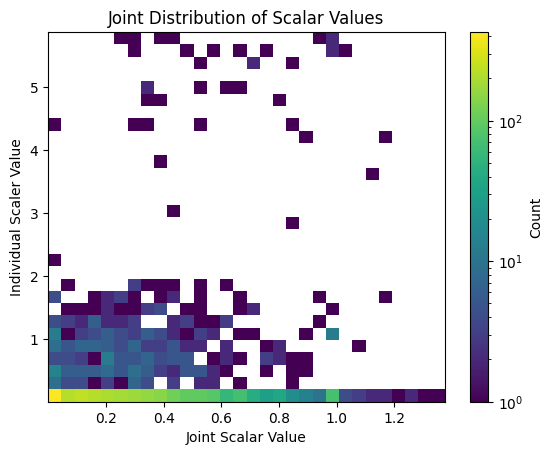

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

# Create 2D histogram
plt.hist2d(joint_scalers, individual_scalers, bins=30, cmap='viridis', norm=matplotlib.colors.LogNorm())
plt.colorbar(label='Count')

plt.title("Joint Distribution of Scalar Values")
plt.xlabel("Joint Scalar Value") 
plt.ylabel("Individual Scaler Value")

plt.show()

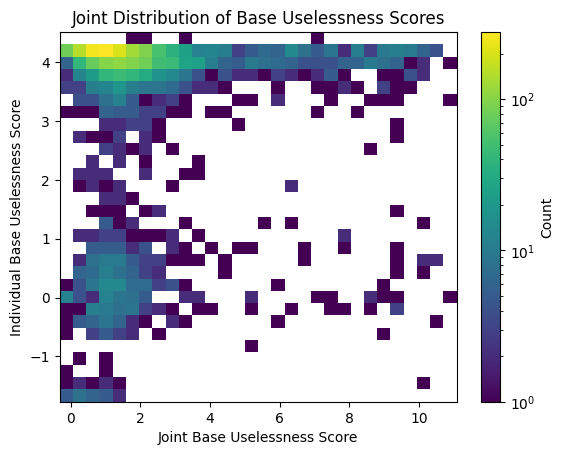

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

# Create 2D histogram
plt.hist2d(joint_base_uselessness_score, individual_base_uselessness_score, bins=30, cmap='viridis', norm=matplotlib.colors.LogNorm())
plt.colorbar(label='Count')

plt.title("Joint Distribution of Base Uselessness Scores")
plt.xlabel("Joint Base Uselessness Score") 
plt.ylabel("Individual Base Uselessness Score")

plt.show()